Warning!: guessed length is not equal to the height. Double check your result 0.019084975450446972 0.3
The sweep gas saturated
 Longer column would not increment the extraction efficiency
TRIOMA eff is  0.013981326148739592
eff_res is  0.013793922628747554
err is  -0.0001874035199920382
Warning!: guessed length is not equal to the height. Double check your result 0.019084975450446972 0.725
The sweep gas saturated
 Longer column would not increment the extraction efficiency


com.comsol.util.exceptions.FlException: Exception:
	com.comsol.util.exceptions.FlException: Failed to find a solution
	(rethrown as com.comsol.util.exceptions.FlException)
Messages:
	The following feature has encountered a problem
	- Feature: Stationary Solver 1 (sol2/s1)

	Failed to find a solution

	Maximum number of Newton iterations reached

	Returned solution is not converged

	Not all parameter steps returned


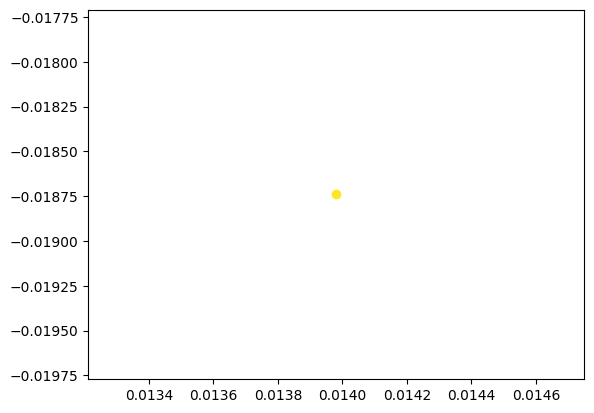

In [6]:
from TRIOMA.tools.component_tools import GLC,GLC_Gas,Fluid
import numpy as np 
import matplotlib.pyplot as plt
import mph 
R_const=8.31
T = 673
Z = 0.8
R = 0.03
Q_l = 80.0 * 1e-3 / 360
Q_gas=np.linspace(6* 1e-3 / 3600,100*1e-3/3600,5)
L_on_g=Q_l/Q_gas
p_in = 1E4
B_vec = []
kl_vec = []
client=mph.start()
model = client.load('GenericMSGLC.mph')
p_in_g_v=np.linspace(0,9000,5)
scatter_mat = np.empty((0, 5))
for p_in_g in p_in_g_v:
    for i in range(len(Q_gas)):
        SweepGas=GLC_Gas(G_gas=Q_gas[i],pg_in=p_in_g,p_tot=1.5E5)
        FLiBe=Fluid(Solubility=7.9E-2*np.exp(-35E3/R_const/T),MS=True )
        c_in=p_in*FLiBe.Solubility
        Melodie=GLC(H=Z,R=R,c_in=p_in*FLiBe.Solubility,fluid=FLiBe,GLC_gas=SweepGas,T=T,G_L=Q_l)
        Melodie.kla=3E-2
        height_v=[]
        err_v=[]
        Z_v=np.linspace(0.3,2,5)
        norm = plt.Normalize(min(Q_l/Q_gas), max(Q_l/Q_gas))
        for height in Z_v:
            Melodie.H=height
            Melodie.get_c_out()
            eff=Melodie.eff
            c_PbLi=56182
            flag_coms=1
            if isinstance(height,float) and flag_coms!=0:
                model.parameter("H",height)
                model.parameter("P",Melodie.GLC_gas.p_tot)
                model.parameter("Ls",Q_l*c_PbLi)
                model.parameter("Vs",Q_gas[i])
                model.parameter("R",R)
                model.parameter("c2_in",p_in_g/R_const/T)
                model.parameter("Kl_a",Melodie.kla)
                model.parameter("c_in",c_in)
                model.parameter("K_H",FLiBe.Solubility)
                model.solve()
                eff_coms=model.evaluate("eff")
                eff_res=eff_coms
                err=eff_res-eff
                print("TRIOMA eff is ",eff)
                print("eff_res is ",eff_res)
                print("err is ",err)    
                err_v.append(err)
                plt.scatter( eff,err*100, c=Q_l/Q_gas[i], cmap='viridis', norm=norm)
                new_row=np.array([height,p_in_g,Q_gas[i],err,eff])
                scatter_mat = np.vstack((scatter_mat, new_row))  # Append the new row

plt.show()


C:\Users\Gabriele\AppData\Local\Temp\ipykernel_23080\866424704.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis')


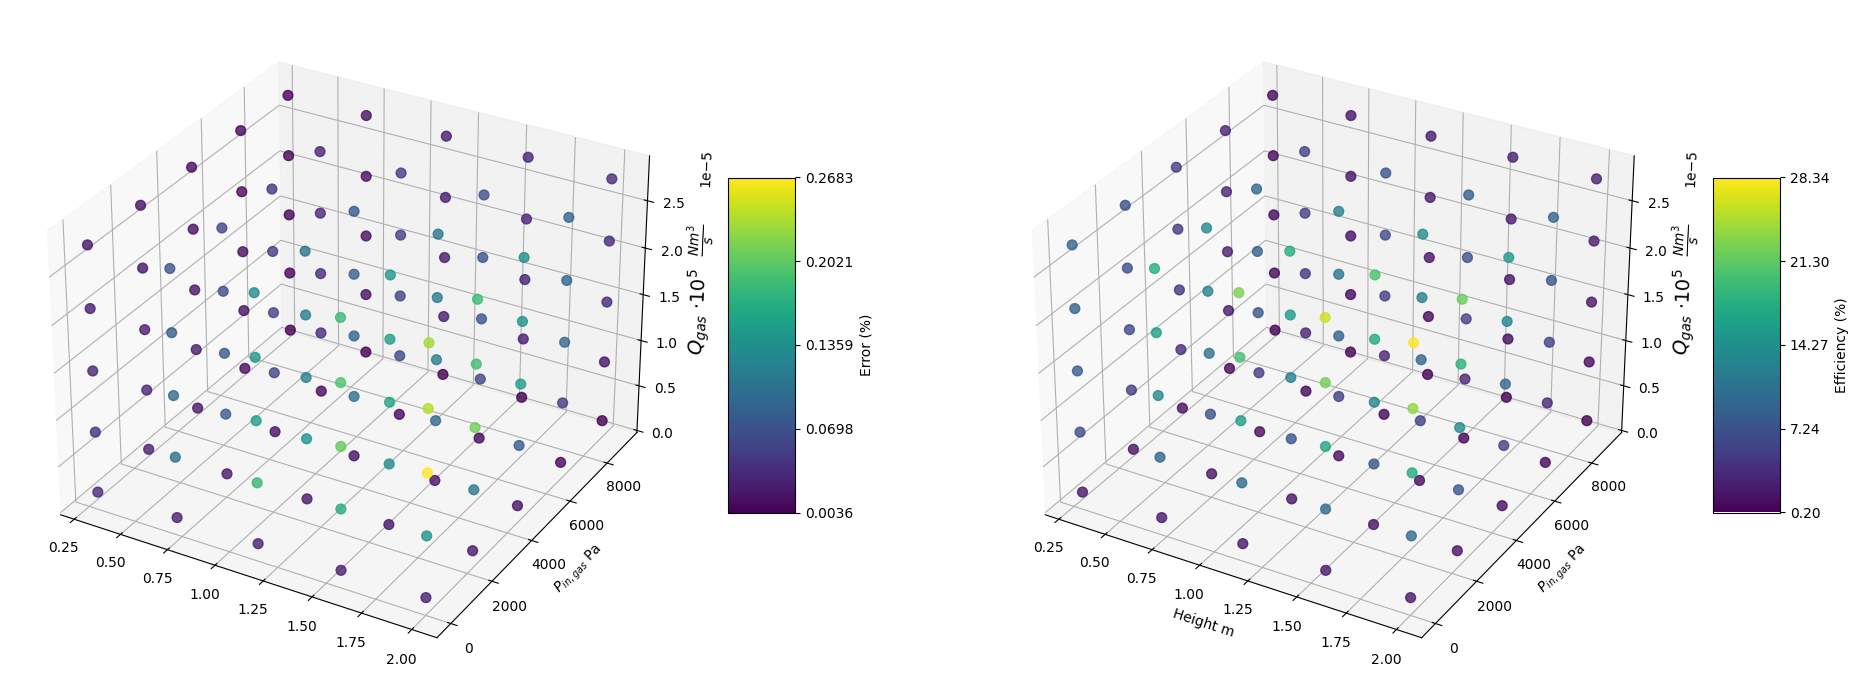

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
scatter_mat[:,3]=scatter_mat[:,3]*100
scatter_mat[:,4]=scatter_mat[:,4]*100

# Normalize the colors based on the values in scatter_mat[:, 3] and scatter_mat[:, 4]
cmap = cm.get_cmap('viridis')
norm1 = plt.Normalize(vmin=abs(scatter_mat[:, 3]).min(), vmax=abs(scatter_mat[:, 3]).max())
norm2 = plt.Normalize(vmin=abs(scatter_mat[:, 4]).min(), vmax=abs(scatter_mat[:, 4]).max())

colors1 = np.array([
    (1, 0, 0, 1) if value > 1 else cmap(norm1(value))  # (1, 0, 0, 1) is red in RGBA
    for value in abs(scatter_mat[:, 3])
])
colors2 = np.array([
    cmap(norm2(value))  # Normalize based on scatter_mat[:, 4]
    for value in abs(scatter_mat[:, 4])
])

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7), subplot_kw={'projection': '3d'})

# First subplot
sc1 = ax1.scatter(scatter_mat[:, 0], scatter_mat[:, 1], scatter_mat[:, 2], c=colors1, s=50, alpha=0.8)
cbar1 = plt.colorbar(cm.ScalarMappable(norm=norm1, cmap=cmap), ax=ax1, shrink=0.5, aspect=5)
cbar1.set_label('Error (%)')
# Set ticks in colorbar according to scatter_mat[:, 3]
cbar1.set_ticks(np.linspace(abs(scatter_mat[:, 3]).min(), abs(scatter_mat[:, 3]).max(), num=5))

# Second subplot
sc2 = ax2.scatter(scatter_mat[:, 0], scatter_mat[:, 1], scatter_mat[:, 2], c=colors2, s=50, alpha=0.8)
cbar2 = plt.colorbar(cm.ScalarMappable(norm=norm2, cmap=cmap), ax=ax2, shrink=0.5, aspect=5)
cbar2.set_label('Efficiency (%)')
# Set ticks in colorbar according to scatter_mat[:, 4]
cbar2.set_ticks(np.linspace(abs(scatter_mat[:, 4]).min(), abs(scatter_mat[:, 4]).max(), num=5))

#ax1.set_xlabel(r'Height m ')
ax1.set_ylabel(r'$P_{in,gas}$ Pa')
ax1.set_zlabel(r'$Q_{gas}$ $\cdot 10^5$  $\frac{Nm^3}{s}$',fontsize=14)
ax2.set_xlabel(r'Height m ')
ax2.set_ylabel(r'$P_{in,gas}$ Pa')
ax2.set_zlabel(r'$Q_{gas}$ $\cdot 10^5$  $\frac{Nm^3}{s}$',fontsize=14)
plt.tight_layout()
plt.savefig('ms_GLC_verification.png', dpi=300)
plt.show()